# Clustering of HCP Unrelated 100 Subjects by ROI-Correlations in Resting State

## Import and Setup

In [20]:
from Main import get_timeseries_per_patient, timeseries_pearson_corr, get_centroids_per_region
from Import import get_parcellation_data
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

In [2]:
# import all timeseries
files = glob("D:/HCP/Unrelated 100/Patients/timeseries/*")
all_timeseries = [np.load(file) for file in files]
len(all_timeseries)

100

In [3]:
# import all centroids
files = glob("./Data/centroids/*")
all_centroids = np.concatenate([np.load(file) for file in files], axis=0)
all_centroids

array([[64.46511628, 59.51928531, 60.82019285],
       [24.44957113, 58.22508134, 61.40490979],
       [54.38649625, 79.74492915, 56.47707697],
       [34.1984714 , 77.95512821, 57.25221893],
       [53.41225337, 85.95950156, 28.64070613],
       [35.9107322 , 86.30892678, 28.25275827],
       [61.87949825, 78.7446021 , 53.06539173],
       [26.30407524, 78.87539185, 52.40713166],
       [60.44256757, 87.57094595, 30.50675676],
       [28.55270936, 88.63743842, 29.92906404],
       [69.39788054, 68.74566474, 44.90077071],
       [20.03645461, 69.83774124, 46.09792709],
       [67.94503756, 77.33333333, 42.29141953],
       [19.9693166 , 77.45095305, 42.40864714],
       [63.12011834, 77.74615385, 29.2704142 ],
       [24.54481547, 78.4973638 , 29.37082601],
       [68.7030303 , 58.11212121, 42.31919192],
       [18.80916604, 59.23140496, 42.6649136 ],
       [47.84536563, 64.77503493, 66.03213787],
       [40.87684521, 62.45339519, 66.25643189],
       [49.13214286, 69.93214286, 29.657

In [4]:
# setup patient num, timestamp and correlation threshold
patients = ["100307", "100408", "101107", "101309", "101915", "103111", "103414", "103818", "105014", "105115", "106016", "108828", "110411", "111312", "111716", "113619", "113922", "114419", "115320", "116524", "117122", "118528", "118730", "118932", "120111", "122317", "122620", "123117", "123925", "124422", "125525", "126325", "127630", "127933", "128127", "128632", "129028", "130013", "130316", "131217", "131722", "133019", "133928", "135225", "135932", "136833", "138534", "139637", "140925", "144832", "146432", "147737", "148335", "148840", "149337", "149539", "149741", "151223", "151526", "151627", "153025", "154734", "156637", "159340", "160123", "161731", "162733", "163129", "176542", "178950", "188347", "189450", "190031", "192540", "196750", "198451", "199655", "201111", "208226", "211417", "211720", "212318", "214423", "221319", "239944", "245333", "280739", "298051", "366446", "397760", "414229", "499566", "654754", "672756", "751348", "756055", "792564", "856766", "857263", "899885"]
patient_num = patients.index("100307")
timestamp = 70
correlation_threshold = 0.75

## Visualize Brain Regions

In [5]:
# pass

## Visualize Timeseries

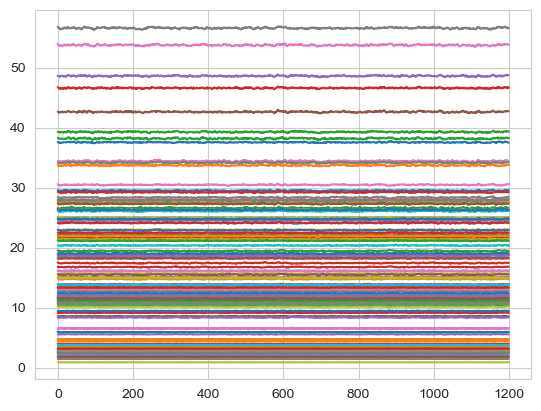

In [6]:
# plot the patients timeseries
timeseries = all_timeseries[patient_num]

plt.plot(timeseries[:, :]);

## Compute Pearson`s r

In [7]:
# compute correlation between regions in sliding window
correlation_matrices_per_patient = timeseries_pearson_corr(timeseries, step_width=5, overlap_percentage=0.2)

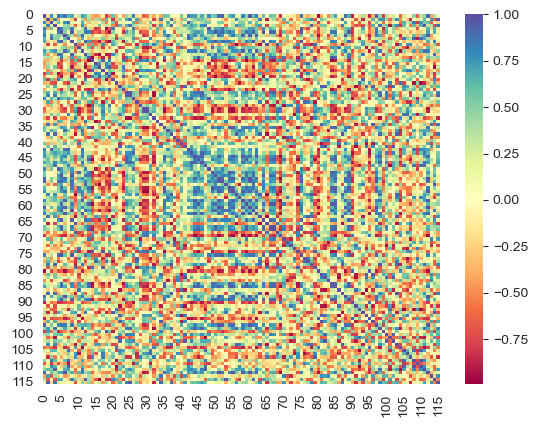

In [8]:
# plot correlation matrix
sns.heatmap(correlation_matrices_per_patient[timestamp], cmap='Spectral');

## Compute and visualize Network Graph

In [9]:
# set diagonal to 0 (no correlation of region with itself), compute absolute value to have only positive correlations and set all values <= threshold to 0
for k in np.arange(len(correlation_matrices_per_patient)):
    for l in np.arange(116):
        correlation_matrices_per_patient[k][l,l] = 0
correlation_matrices_per_patient_abs = np.abs(correlation_matrices_per_patient)
correlation_matrices_per_patient_abs_thresh = correlation_matrices_per_patient_abs * (correlation_matrices_per_patient_abs>correlation_threshold)

In [10]:
# compute network graph
graph = nx.from_numpy_array(correlation_matrices_per_patient_abs_thresh[timestamp])

In [11]:
# compute weights of connections based on correlation
all_weights = []
for (node1, node2, data) in graph.edges(data=True):
    all_weights.append(correlation_matrices_per_patient_abs_thresh[timestamp][node1, node2])

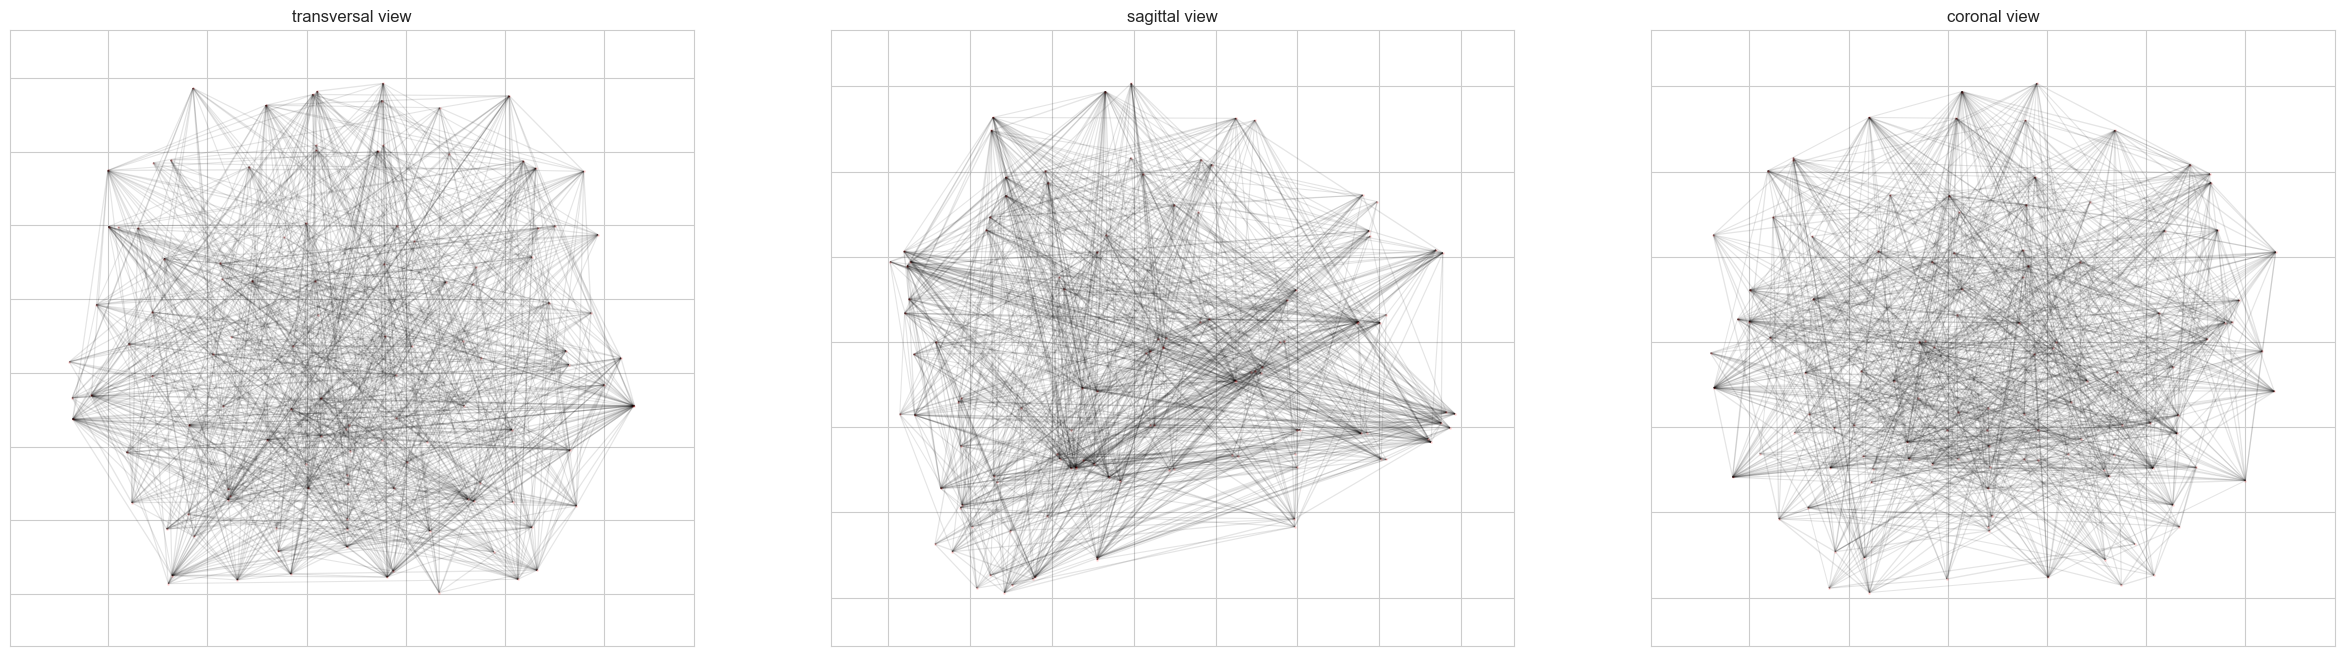

In [12]:
# plot 2D network graph with custom positions
fig, axs = plt.subplots(1, 3, figsize=(30, 8))
views = [all_centroids[:, 0:2], all_centroids[:, 1:3], all_centroids[:, 0:3:2]]
titles = ["transversal view", "sagittal view", "coronal view"]
for ax_num, ax in enumerate(axs):
    pos = views[ax_num]
    nx.draw_networkx(graph, pos=pos, alpha=0.1, node_size=1, node_color="red", width=all_weights, with_labels=False, ax=ax)
    ax.set_title(titles[ax_num])

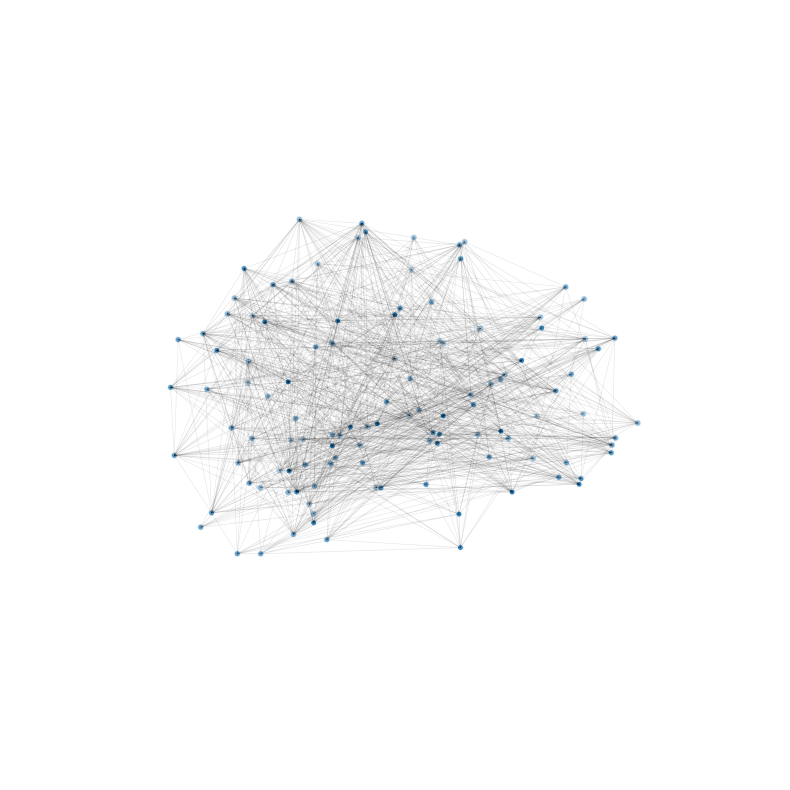

In [48]:
pos = all_centroids
node_pos = pos
edge_pos = np.array([(pos[u], pos[v]) for u, v in graph.edges])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(*node_pos.T, s=20, ec="w")
for edge_num in np.arange(edge_pos.shape[0]):
    ax.plot3D(xs=(edge_pos[edge_num, 0, 0], edge_pos[edge_num, 1, 0]), ys=(edge_pos[edge_num, 0, 1], edge_pos[edge_num, 1, 1]), zs=(edge_pos[edge_num, 0, 2], edge_pos[edge_num, 1, 2]), color="black", linewidth=all_weights[edge_num]*0.5, alpha=0.1)
ax.view_init(15, 15)
ax.set_axis_off()